#  Прогнозирование заказов такси

### Импорт библиотек

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Подготовка данных

In [4]:
taxi = pd.read_csv('/content/taxi.csv')

In [5]:
taxi.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Дата пока является объектом, пропуков нет, перейдем к подготовке данных

### Подготовка данных

In [7]:
taxi.duplicated().sum()

0

Дубликатов нет, поэтому сейчас можно перевести время в дататайм и перенести его в индекс, чтобы было удобно работать. 

In [8]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'], format = '%Y-%m-%d %H:%M:%S')
taxi.index = taxi['datetime']
taxi = taxi.drop('datetime', 1)
taxi.index.is_monotonic

True

Проверка прошла успешно, время возрастает, временной ряд мононтонный.

### Ресэмплинг

In [9]:
taxi = taxi.resample('1H').sum()

In [10]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Ресэмплинг служит для уменьшения строк и прогнозирования с более широкими рамками времени.

## Анализ

Посмотрим графически на тренд, сезонность и остатки.

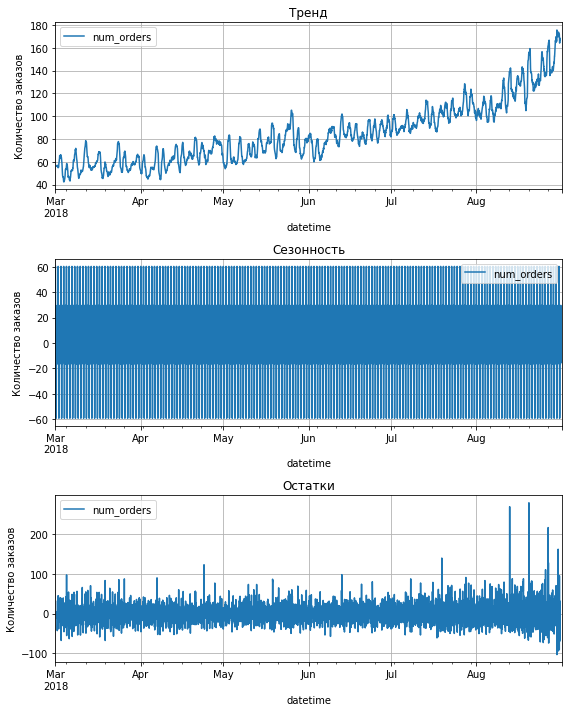

In [11]:
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(8, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca(), grid = True)
plt.title('Тренд')
plt.ylabel('Количество заказов')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca(), grid = True)
plt.title('Cезонность')
plt.ylabel('Количество заказов')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca(), grid = True) 
plt.title('Остатки')
plt.ylabel('Количество заказов')
plt.tight_layout()

Графики не вполне понятны. При прогнозировании на час, тренд в несколько месяцев - избыточен, поэтому уменьшу временной интревал сначала дом месяца, затем до 2 недель.

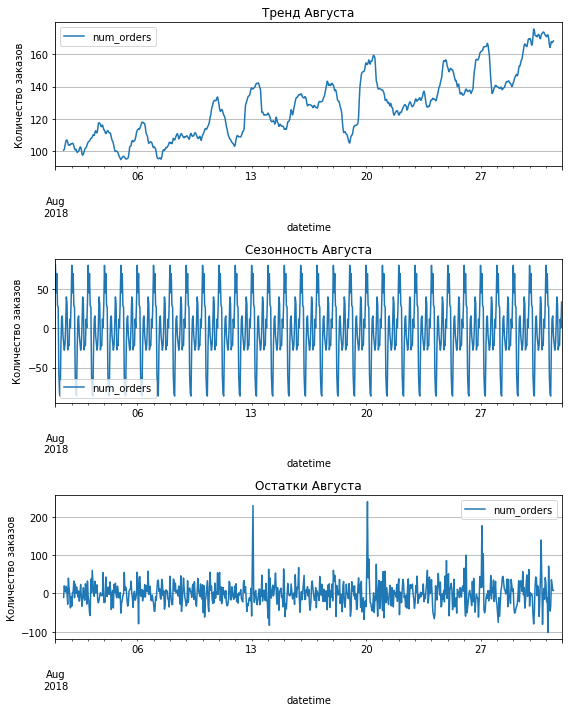

In [12]:
decomposed_1 = seasonal_decompose(taxi['2018-08-01':])

plt.figure(figsize=(8, 10))
plt.subplot(311)

decomposed_1.trend.plot(ax=plt.gca(), grid = True)
plt.title('Тренд Августа')
plt.ylabel('Количество заказов')
plt.subplot(312)

decomposed_1.seasonal.plot(ax=plt.gca(), grid = True)
plt.title('Cезонность Августа')
plt.ylabel('Количество заказов')
plt.subplot(313)

decomposed_1.resid.plot(ax=plt.gca(), grid = True) 
plt.title('Остатки Августа')
plt.ylabel('Количество заказов')
plt.tight_layout()

Можно взглянуть отдельно на сезонность и ее увеличить.

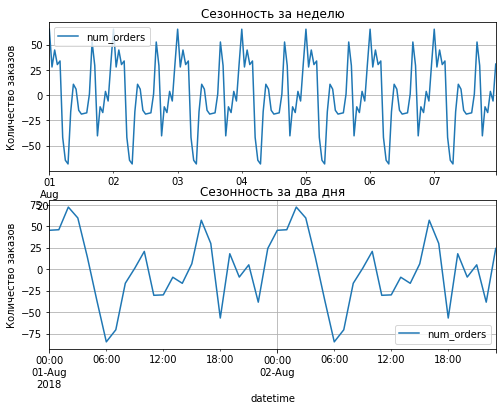

In [13]:
decomposed_2 = seasonal_decompose(taxi['2018-08-01':'2018-08-07'])

plt.figure(figsize=(8, 6))
plt.subplot(211)
decomposed_2.seasonal.plot(ax=plt.gca(), grid = True)
plt.title('Cезонность за неделю')
plt.ylabel('Количество заказов')


decomposed_3 = seasonal_decompose(taxi['2018-08-01':'2018-08-02'])

plt.subplot(212)
decomposed_3.seasonal.plot(ax=plt.gca(), grid = True)
plt.title('Cезонность за два дня')
plt.ylabel('Количество заказов')

del decomposed_1, decomposed_2, decomposed_3

За первую неделю августа можно сказать, что пик приходится чуть за полночь, а под утро идет довольно резкий спад, восстанавливающийся ближе к середине дня, и потом снова спад. Это график такси в аэропорту, поэтому во время утреннего и вечернего часа пик машин мало, т.к. люди, видимо, выбирают альтернативные способы добраться до аэропорта или дома, а такси будет забирать очень много времени (и денег). 

Сезонная составляющая - это периодически повторяющаяся компонента, поэтому она не зависит от месяца или дня недели и повторяется каждый день. Но если мы просуммируем значения за день и посмотрим на дневную сезонность?

Text(0, 0.5, 'Количество заказов')

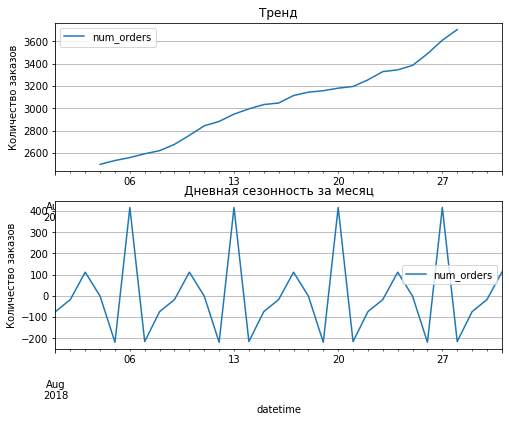

In [14]:
taxi1 = taxi.resample('1d').sum().copy()

decomposed_1 = seasonal_decompose(taxi1['2018-08':])

plt.figure(figsize=(8, 6))
plt.subplot(211)
decomposed_1.trend.plot(ax=plt.gca(), grid = True)
plt.title('Тренд')
plt.ylabel('Количество заказов')

plt.subplot(212)
decomposed_1.seasonal.plot(ax=plt.gca(), grid = True)
plt.title('Дневная сезонность за месяц')
plt.ylabel('Количество заказов')

При ресэмплинге по дням тренд не меняется, он всё так же восходящий, а график сезонности изменился. Теперь пики по субботам. И видимо, по субботам ночью.. Наверное, тогда и больше всего рейсов.

Посмотрим на скользящее среднее.

Text(0, 0.5, 'Количество заказов')

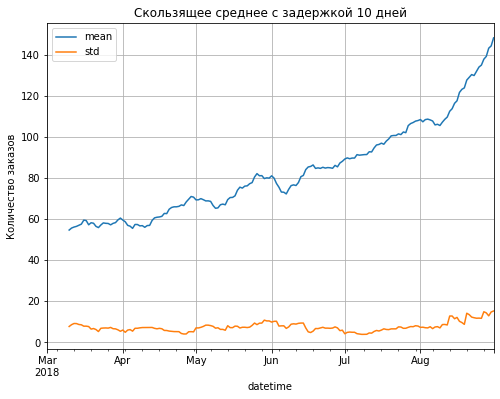

In [15]:
taxi1 = taxi.copy()
taxi1 = taxi1.resample('1D').mean()
taxi1['mean'] = taxi1['num_orders'].rolling(10).mean()
taxi1['std'] = taxi1['num_orders'].rolling(10).std()
taxi1[['mean', 'std']].plot(grid = True, figsize = (8,6)) 
plt.title('Скользящее среднее с задержкой 10 дней')
plt.ylabel('Количество заказов')

In [16]:
del taxi1

**Вывод**

Графики с усреднением по 1 часу и по 1 дню показывают, что с количество заказов с течением года только растет, поэтому мы имеем дело с нестационарным стахостическим временным рядом. 

А с другой стороны, глядя на график, видно, что угол наклона аппроксимирующей прямой меняется после середины июня. 

## Обучение моделей

### Подготовка признаков

Для начала добавим немного признаков в наш датаферйм: день недели, час заказа, временной лаг в 1 и 2 часа и скользящее среднее. 

Год и день нам не нужны, т.к. это слишком большие факторы для прогноза на 1 час вперед. 

In [17]:
taxi['dayofweek'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour

for lag in range(1, 3):
    taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)

taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(24).mean()

In [18]:
taxi.head(3)

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN


Вот такой набор фич, подчистим наны и запустим модельки. 

In [19]:
taxi = taxi.dropna()

In [20]:
X = taxi.drop('num_orders', 1)
y = taxi['num_orders']

In [21]:
X_train, X_test, y_train, y_test = train_test_split (X, y, shuffle = False, test_size = 0.1)

In [22]:
print ('Размер обучающей выборки: ', X_train.shape[0])
print ('Размер тестовой выборки: ', X_test.shape[0])

Размер обучающей выборки:  3952
Размер тестовой выборки:  440


### Дамми Регрессор

Начнем с самой простой модельки, которая нам предскажет просто медианы.

In [23]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit (X_train, y_train)
dummy_pred = dummy_regr.predict (X_test)
dummy_rmse = (mean_squared_error (y_test, dummy_pred))**0.5 

print('RMSE медианной модели: {:.4f}'.format(dummy_rmse) )

RMSE медианной модели: 87.2109


In [24]:
# Добавление даннных для финального отчета
data = []
data_columns = ['model', 'RMSE',]
string = ['Dummy Median', dummy_rmse]

data.append(string)

### Дерево решений

Отмасштабируем призаки для лучшей работы модели

In [25]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(X_train) 

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Запускаем модель дерева решений

In [26]:
model_tree = DecisionTreeRegressor(random_state = 15)
from sklearn.model_selection import TimeSeriesSplit

#Создание сетки для выбора лучших параметров
param_grid_tree = {
    'max_depth' : range(9, 13),
    'min_samples_leaf' : range(10,15)
}

split_index = TimeSeriesSplit(n_splits=8).split(X_train)

grid_tree = GridSearchCV(estimator = model_tree, param_grid = param_grid_tree, 
                         scoring = 'neg_mean_squared_error', error_score='raise',
                         cv=split_index)
grid_tree.fit(X_train, y_train)

print('Гиперпараметры модели:', grid_tree.best_params_)

#Расчет RMSE для тестовой выборки
tree_rmse = (mean_squared_error(y_test, grid_tree.predict(X_test)))**0.5

print('Tree. Test best RMSE: {:.3f}'.format(tree_rmse))

#Добавление строки в отчет
string = ['DecisionTree', tree_rmse]

data.append(string)

Гиперпараметры модели: {'max_depth': 12, 'min_samples_leaf': 13}
Tree. Test best RMSE: 53.774


### Линейная регрессия

In [27]:
model_lin = LinearRegression()

model_lin.fit(X_train, y_train)

pred_lin = model_lin.predict(X_test)

In [28]:
#Расчет RMSE для тестовой выборки
lin_rmse = (mean_squared_error(y_test, pred_lin))**0.5

print('LinearRegression. Test best RMSE: {:.3f}'.format(lin_rmse))

#Добавление строки в отчет
string = ['LinearRegression', lin_rmse]

data.append(string)

LinearRegression. Test best RMSE: 51.296


### Случайный лес

In [29]:
model_forest = RandomForestRegressor(random_state = 15)

#Создание сетки для выбора лучших параметров
param_grid_forest = {
    'max_depth' : range(9,13),
    'n_estimators': range(40, 71, 10)
}

split_index = TimeSeriesSplit(n_splits=8).split(X_train)

grid_forest = GridSearchCV(estimator = model_forest, param_grid = param_grid_forest, 
                         scoring = 'neg_mean_squared_error', error_score='raise',cv = split_index)

grid_forest.fit(X_train, y_train)


print('Гиперпараметры модели:', grid_forest.best_params_)

#Расчет RMSE для тестовой выборки
forest_pred = grid_forest.predict(X_test)
forest_rmse = (mean_squared_error(y_test, forest_pred))**0.5

print('Tree. Test best RMSE: {:.3f}'.format(forest_rmse))

#Добавление строки в отчет
string = ['RandomForest', forest_rmse]

data.append(string)

Гиперпараметры модели: {'max_depth': 12, 'n_estimators': 70}
Tree. Test best RMSE: 45.962


### Catboost

Кэтбуст и без настроек неплохо работает. 

In [30]:
cb = CatBoostRegressor(verbose=200, random_seed = 15)
cb.fit(X_train, y_train, eval_set=(X_test,y_test))
cb_predict = cb.predict(X_test)

print('Лучшее значение RMSE для Catboost', cb.best_score_['validation']['RMSE'])

#Добавление строки в отчет
string = ['CatBoost', cb.best_score_['validation']['RMSE']]

data.append(string)

Learning rate set to 0.063182
0:	learn: 37.5499561	test: 83.0942559	best: 83.0942559 (0)	total: 49.6ms	remaining: 49.5s
200:	learn: 20.1155691	test: 46.9077488	best: 46.9077488 (200)	total: 366ms	remaining: 1.45s
400:	learn: 17.8392051	test: 45.1367367	best: 45.0898274 (383)	total: 692ms	remaining: 1.03s
600:	learn: 16.5314724	test: 45.0199455	best: 44.9404712 (517)	total: 1s	remaining: 665ms
800:	learn: 15.4508974	test: 45.3558851	best: 44.9404712 (517)	total: 1.33s	remaining: 330ms
999:	learn: 14.5778162	test: 45.4152216	best: 44.9404712 (517)	total: 1.66s	remaining: 0us

bestTest = 44.94047122
bestIteration = 517

Shrink model to first 518 iterations.
Лучшее значение RMSE для Catboost 44.9404712170934


## Результат работы моделей

Т.к. тестирование было сразу при обучении моделей, то тут выведу только результаты тестирования

In [31]:
res = pd.DataFrame(data = data, columns = ['Model', 'RMSE'])

In [32]:
res

,Model,RMSE
0,Dummy Median,87.210938
1,DecisionTree,53.774010
2,LinearRegression,51.296368
3,RandomForest,45.962306
4,CatBoost,44.940471


Чтобы увеличить масштаб около 48, я выкину дамми регрессор из графика

Text(0.5, 1.0, 'Значение RMSE в зависимости от модели')

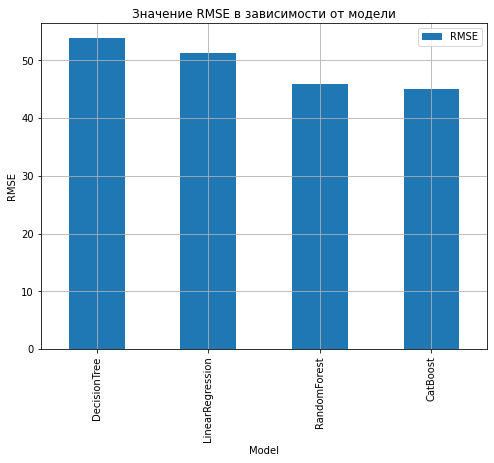

In [33]:
res = res[res['Model'] != 'Dummy Median']
res.index = res['Model']
res.plot(kind = 'bar', grid = True, figsize = (8,6))
plt.ylabel ('RMSE')
plt.title ('Значение RMSE в зависимости от модели')

Как видно, заветную отметку в 48 лишних (или недостающих) машин перодолели только Случайный лес и Кэтбуст. Построю для них графики с правильными ответами и предсказаниями.

**RandomForest**

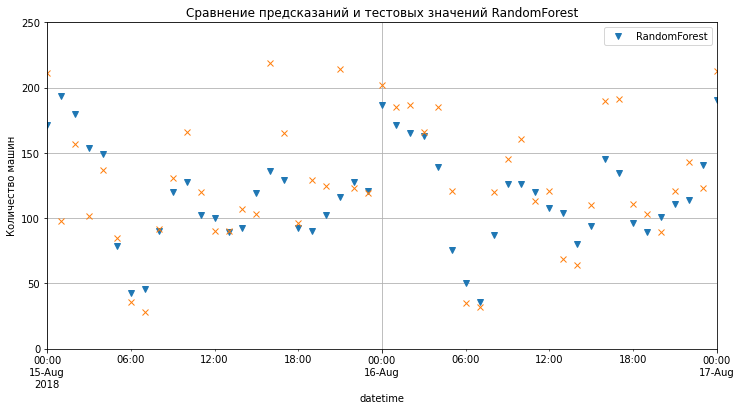

In [34]:
pd.DataFrame(data = forest_pred, columns = ['RandomForest'], index = y_test.index).plot(style = 'v')
y_test.plot(style = 'x', figsize = (12,6), grid = True, xlim = ['2018-08-15','2018-08-17'], ylim=[0, 250])
plt.title ('Сравнение предсказаний и тестовых значений RandomForest')
plt.ylabel ('Количество машин')
plt.show()

Крестики - правильные ответы, треугольнички - предсказания.

**Вывод**

Получается, что в среднем, наша модель ошибается в минус, и скорее всего наши клиенты уйдут к конкурирующему таксопарку.. Не самый хороший результат. Но посмотрим на результат кэтбуста.

**Catboost**

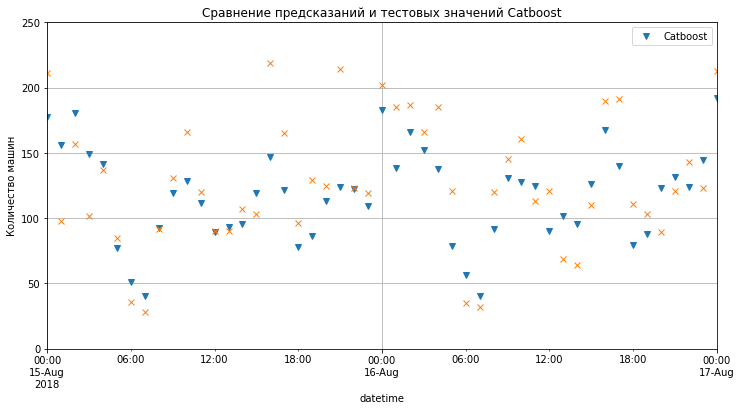

In [35]:
pd.DataFrame(data = cb_predict, columns = ['Catboost'], index = y_test.index).plot(style = 'v')
y_test.plot(style = 'x', figsize = (12,6), grid = True, xlim = ['2018-08-15','2018-08-17'], ylim=[0, 250])
plt.title ('Сравнение предсказаний и тестовых значений Catboost')
plt.ylabel ('Количество машин')
plt.show()

Крестики - правильные ответы, треугольнички - предсказания.

В среднем опять получается, что машин нам обычно не хватает, нежели они простаивают.. Лучше было бы наоборот.. А что будет если добавить каждый час по 15 машин, например? Проверим!

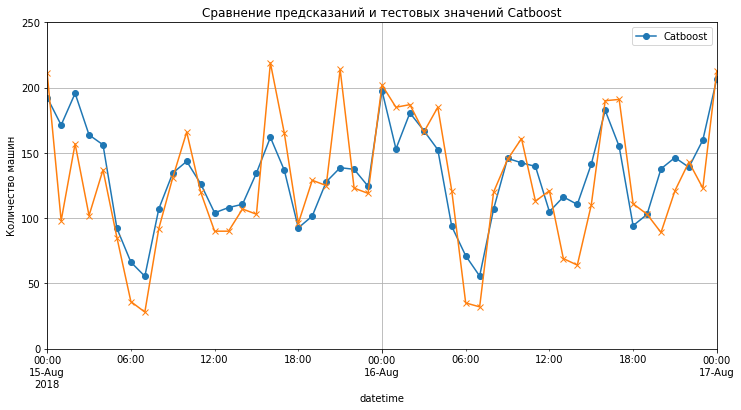

In [36]:
cb_predict += 15

cb2_rmse = (mean_squared_error(y_test, cb_predict))**0.5

pd.DataFrame(data = cb_predict, columns = ['Catboost'], index = y_test.index).plot(style = '-o')
y_test.plot(style = '-x', figsize = (12,6), grid = True, xlim = ['2018-08-15','2018-08-17'], ylim=[0, 250])

plt.title ('Сравнение предсказаний и тестовых значений Catboost')
plt.ylabel ('Количество машин')
plt.show()

In [37]:
print('Кэтбуст с небольшой добавкой, конечный RMSE: {:.3f}'.format(cb2_rmse))

Кэтбуст с небольшой добавкой, конечный RMSE: 41.637


## Вывод


С небольшой ручной добавкой в 15 машин мы получили снижение метрики RMSE на 6 единиц или на 8%. Неплохой результат, а? Но это подсветило проблему, что модель недостаточно учитывает тренд (по месяцам). На графике в самом начале было видно, что в августе идет сильный рост по сравнению с предыдущими месяцами, но модель этого знать не могла и не учла. 
Желательно бы, конечно, учитвать еще и годовую сезонность, чтобы предсказания были более точными. 
А также видно, что модель плохо работает с дневной сезонностью (по часам) и в период пиков или просадок притягивает предсказания к среднему, поэтому утром водителей предсказано слишком много, а в вечерний час-пик машин не хватает..